<a href="https://colab.research.google.com/github/flora0110/podcast_segment_headine/blob/main/%E3%80%8C%E3%80%8Cpodcast_to_headline_del_spon_movie_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textsplit

In [ ]:
!pip install word2vec

     |████████████████████████████████| 42 kB 975 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156420 sha256=64e1f4262f6b3dde3b0ec5e5764a891a0830df6b72f48e2036cc8d67d9fb5b0b
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [ ]:
import os
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [ ]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

--2022-05-12 20:47:22--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.24
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  3.63MB/s    in 8.2s    

2022-05-12 20:47:30 (3.63 MB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  ./text8.zip
  inflating: text8                   


In [ ]:
links = {'podcast_text': 'https://raw.githubusercontent.com/grace-boop/podcast/main/A_Marriage_Movie'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

--2022-05-12 20:47:32--  https://raw.githubusercontent.com/grace-boop/podcast/main/A_Marriage_Movie
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18895 (18K) [text/plain]
Saving to: ‘A_Marriage_Movie’

A_Marriage_Movie    100%[===================>]  18.45K  --.-KB/s    in 0s      

2022-05-12 20:47:32 (74.9 MB/s) - ‘A_Marriage_Movie’ saved [18895/18895]



## Train wordvectors

In [ ]:
import logging
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
  sentences = word2vec.Text8Corpus('./text8')
  model = word2vec.Word2Vec(sentences, cbow_mean=1, iter=5, hs=1, sample=0.00001, window=15, size=200)

In [ ]:
model.save(wrdvec_path)

In [ ]:
model = word2vec.Word2Vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.vocab)

## get sentence tokenizer

In [ ]:
!pip install textsplit

     |████████████████████████████████| 154 kB 30.6 MB/s 


In [ ]:
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [ ]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

### podcast

In [ ]:
#@title segment target length in sentences { display-mode: "form" }
segment_len =  25#@param {type:"integer"}

31.609108671404197
penalty 41.78
316 sentences, 11 segments, avg 28.73 sentences per segment
optimal score 6720.70, greedy score 6716.55
[6720.696665806747, 6716.552376936554]
(6720.696665806747, 6716.552376936554)
ratio of scores 1.0006


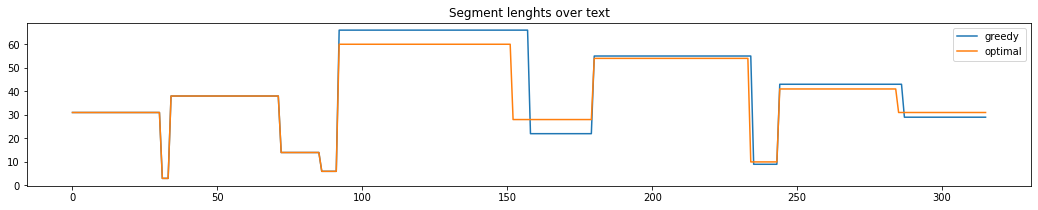

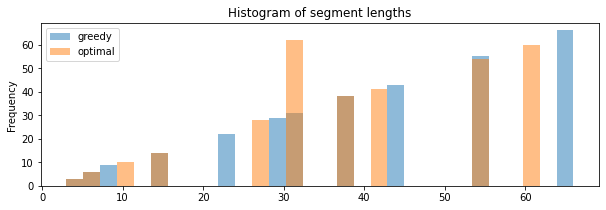

In [ ]:
link = links['podcast_text']
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
strs = " "
for i in range(len(sentenced_text)):
  if(sentenced_text[i] != " "):
    strs =sentenced_text[i]
  if(i+1<len(sentenced_text)):
    if(strs == sentenced_text[i+1]):
      sentenced_text[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)
new_length = len(sentenced_text)**0.6
print(new_length)
penalty = get_penalty([sentence_vectors], new_length)
#penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

#### 顯示分段

In [ ]:
for i in range(len(segmented_text)):
  print(segmented_text[i])
  

[' Since pride month is upon us. ', 'I figured I join in on the self-serving worthless pondering. ', "So I'm happy to declare that from now on that. ", 'This is an lgbtq on a plus Channel. ', 'Well. ', "Ironically enough this video how to sponsor nordvpn virtual private network will keep you safe and secure husky pesky government, but the benefits don't end there. ", "Movie or show you want to watch isn't available Way You Are. ", 'No one has thousands of super fall service located, all across the world, allowing you to get around, Regional restrictions and enjoy more content of shopping around to get yourself. ', "The best deal was based on what I found it very useful, especially when watching content online with my girlfriend and maybe you'll find it useful to protect yourself online. ", 'Get better deals plus all these other benefits and support your favorite YouTube channel. ', 'What more could you want get a huge discount on a 2-year plan of plus an extra months of free by going t

In [ ]:
first_sentence = []
for i in range(len(segmented_text)):
  first_sentence.append(segmented_text[i][0].strip().rstrip().rstrip('.').rstrip('?'))
  print(segmented_text[i][0])
  print(type(segmented_text[i][0]))
  print(len(segmented_text[i]))
print(first_sentence)
1

 Since pride month is upon us. 
<class 'str'>
31
So there's nothing wrong with this movie in principle. 
<class 'str'>
3
In every respect, you can think of Ben and author is a terrible film. 
<class 'str'>
38
The music is the public domain, which would be fine. 
<class 'str'>
14
Oh boy. 
<class 'str'>
6
I just fell right out onto the floor. 
<class 'str'>
60
That is glorious? 
<class 'str'>
28
Raise. 
<class 'str'>
54
Really doesn't Justice. 
<class 'str'>
10
Even referred him to a hit man. 
<class 'str'>
41
So good for him on frankly. 
<class 'str'>
31
['Since pride month is upon us', "So there's nothing wrong with this movie in principle", 'In every respect, you can think of Ben and author is a terrible film', 'The music is the public domain, which would be fine', 'Oh boy', 'I just fell right out onto the floor', 'That is glorious', 'Raise', "Really doesn't Justice", 'Even referred him to a hit man', 'So good for him on frankly']


1

In [ ]:
print(sentenced_text)

[' Since pride month is upon us. ', 'I figured I join in on the self-serving worthless pondering. ', "So I'm happy to declare that from now on that. ", 'This is an lgbtq on a plus Channel. ', 'Well. ', "Ironically enough this video how to sponsor nordvpn virtual private network will keep you safe and secure husky pesky government, but the benefits don't end there. ", "Movie or show you want to watch isn't available Way You Are. ", 'No one has thousands of super fall service located, all across the world, allowing you to get around, Regional restrictions and enjoy more content of shopping around to get yourself. ', "The best deal was based on what I found it very useful, especially when watching content online with my girlfriend and maybe you'll find it useful to protect yourself online. ", 'Get better deals plus all these other benefits and support your favorite YouTube channel. ', 'What more could you want get a huge discount on a 2-year plan of plus an extra months of free by going t

### 處理輸入

In [ ]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [ ]:
print(podcast_test)

[" Since pride month is upon us. I figured I join in on the self-serving worthless pondering. So I'm happy to declare that from now on that. This is an lgbtq on a plus Channel. Well. Ironically enough this video how to sponsor nordvpn virtual private network will keep you safe and secure husky pesky government, but the benefits don't end there. Movie or show you want to watch isn't available Way You Are. No one has thousands of super fall service located, all across the world, allowing you to get around, Regional restrictions and enjoy more content of shopping around to get yourself. The best deal was based on what I found it very useful, especially when watching content online with my girlfriend and maybe you'll find it useful to protect yourself online. Get better deals plus all these other benefits and support your favorite YouTube channel. What more could you want get a huge discount on a 2-year plan of plus an extra months of free by going to nordvpn.com cynical reviews and using 

# Headline generator

In [ ]:
! pip install transformers datasets

     |████████████████████████████████| 4.2 MB 27.2 MB/s 
     |████████████████████████████████| 342 kB 51.8 MB/s 
     |████████████████████████████████| 596 kB 45.7 MB/s 
     |████████████████████████████████| 6.6 MB 39.0 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 136 kB 62.5 MB/s 
     |████████████████████████████████| 1.1 MB 41.6 MB/s 
     |████████████████████████████████| 212 kB 46.9 MB/s 
     |████████████████████████████████| 127 kB 41.3 MB/s 
     |████████████████████████████████| 144 kB 46.0 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 271 kB 4.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
E

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 23.0 MB/s 


In [ ]:
from transformers import pipeline

## 使用Michau/t5-base-en-generate-headline

In [ ]:
headlineGenerator = pipeline(model="Michau/t5-base-en-generate-headline", tokenizer="Michau/t5-base-en-generate-headline")

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

In [ ]:
#@title 生成標題的長度 { display-mode: "form" }
min_length =  5#@param {type:"integer"}
max_length = 150#@param {type:"integer"}

In [ ]:
headlines = headlineGenerator(podcast_test, min_length, max_length)


Ignoring args : (5, 150)
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors


### 顯示結果

In [ ]:
for headline in headlines:
  print(headline)
  print(type(headline))

{'generated_text': 'The Best VPN For Gays'}
<class 'dict'>
{'generated_text': 'Bots. Bots. Bots. Bots. Bots. Bots. Bot'}
<class 'dict'>
{'generated_text': 'The Movie Is a Bad Movie'}
<class 'dict'>
{'generated_text': 'The School of Vybz'}
<class 'dict'>
{'generated_text': "I'm a gay man, I'm a gay man, I'm"}
<class 'dict'>
{'generated_text': 'The Entertainer - A Gay Rights Movie'}
<class 'dict'>
{'generated_text': 'The Movie Marevich - A Novel About a Gay Man'}
<class 'dict'>
{'generated_text': 'Is It a Good Idea to Get Married?'}
<class 'dict'>
{'generated_text': 'The Priest Is The Most Appropriate Costing'}
<class 'dict'>
{'generated_text': 'The Movie Review'}
<class 'dict'>
{'generated_text': 'The Onlyfans - A Video of Me Llicking My Microphone'}
<class 'dict'>


In [ ]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['The Best VPN For Gays']
['The Best VPN For Gays']
<class 'str'>
['Bots', '.', 'Bots', '.', 'Bots', '.', 'Bots', '.', 'Bots', '.', 'Bots', '.', 'Bot']
['Bots', '.', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'Bot']
<class 'str'>
['The Movie Is a Bad Movie']
['The Movie Is a Bad Movie']
<class 'str'>
['The School of Vybz']
['The School of Vybz']
<class 'str'>
["I'm a gay man", ',', "I'm a gay man", ',', "I'm"]
["I'm a gay man", ',', ' ', ' ', "I'm"]
<class 'str'>
['The Entertainer', '-', 'A Gay Rights Movie']
['The Entertainer', '-', 'A Gay Rights Movie']
<class 'str'>
['The Movie Marevich', '-', 'A Novel About a Gay Man']
['The Movie Marevich', '-', 'A Novel About a Gay Man']
<class 'str'>
['Is It a Good Idea to Get Married?']
['Is It a Good Idea to Get Married?']
<class 'str'>
['The Priest Is The Most Appropriate Costing']
['The Priest Is The Most Appropriate Costing']
<class 'str'>
['The Movie Review']
['The Movie Review']
<class 'str'>
['The Onlyfans', '-', 'A Video of Me Ll

In [ ]:
for headline_string in headlines_string:
  print(headline_string)

 The Best VPN For Gays
 Bots . Bot
 The Movie Is a Bad Movie
 The School of Vybz
 I'm a gay man , I'm
 The Entertainer - A Gay Rights Movie
 The Movie Marevich - A Novel About a Gay Man
 Is It a Good Idea to Get Married?
 The Priest Is The Most Appropriate Costing
 The Movie Review
 The Onlyfans - A Video of Me Llicking My Microphone


In [ ]:
print(headlines_string)
1

[' The Best VPN For Gays', ' Bots . Bot', ' The Movie Is a Bad Movie', ' The School of Vybz', " I'm a gay man , I'm", ' The Entertainer - A Gay Rights Movie', ' The Movie Marevich - A Novel About a Gay Man', ' Is It a Good Idea to Get Married?', ' The Priest Is The Most Appropriate Costing', ' The Movie Review', ' The Onlyfans - A Video of Me Llicking My Microphone']


1

In [ ]:
b = "abc, ss dd, www"
a = re.split(r"([,])",b)
print(a)

['abc', ',', ' ss dd', ',', ' www']


# 去掉廣告

In [ ]:
!pip install -U scikit-learn
!pip install --user -U nltk

     |████████████████████████████████| 1.5 MB 20.9 MB/s 
     |████████████████████████████████| 749 kB 50.2 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## 使用停使用停用詞(NLTK)

In [ ]:
# 下面的代碼是使用nltk從句子中去除停用詞 
# 導入包 
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download("stopwords")
#set(stopwords.words('english')) 
# 例句 
#text = """He determined to drop his litigation with the monastry, and relinguish his claims to the wood-cuting and fishery rihgts at once. He was the more ready to do this becuase the rights had become much less valuable, and he had indeed the vaguest idea where the wood and river in question were.""" 
# 停用詞集合 
stop_words = set(stopwords.words('english')) 
# 分詞 
nltk.download('punkt')
result_nltk = []
for sent in podcast_test:
  word_tokens = word_tokenize(sent) 
  filtered_sentence = [] 
  for w in word_tokens: 
    if w not in stop_words: 
      filtered_sentence.append(w) 
  result_nltk.append(" ".join(filtered_sentence))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print(len(result_nltk))
print(result_nltk)

11
["Since pride month upon us . I figured I join self-serving worthless pondering . So I 'm happy declare . This lgbtq plus Channel . Well . Ironically enough video sponsor nordvpn virtual private network keep safe secure husky pesky government , benefits n't end . Movie show want watch n't available Way You Are . No one thousands super fall service located , across world , allowing get around , Regional restrictions enjoy content shopping around get . The best deal based I found useful , especially watching content online girlfriend maybe 'll find useful protect online . Get better deals plus benefits support favorite YouTube channel . What could want get huge discount 2-year plan plus extra months free going nordvpn.com cynical reviews using code . Well , cynical reviews . I mean , else would possible risk-free 30-day , money-back guarantee . Nothing lose description link I 'm stranger buy moral message movies . In fact , one favorite subjects cover channel . That 's something movie

In [ ]:
vectorizer_nltk = CountVectorizer()
transformer_nltk = TfidfTransformer()
tfidf_nltk = transformer_nltk.fit_transform(vectorizer_nltk.fit_transform(result_nltk))
feature_name_nltk = vectorizer_nltk.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(len(feature_name_nltk))
print(feature_name_nltk)

999
['11', '2003', '30', 'able', 'absolutely', 'accept', 'access', 'accompanied', 'across', 'acting', 'action', 'actor', 'actual', 'actually', 'added', 'address', 'admitted', 'admitting', 'adult', 'advises', 'afraid', 'after', 'again', 'ahead', 'alcohol', 'all', 'allowing', 'already', 'also', 'altar', 'alter', 'amateur', 'amazing', 'american', 'an', 'anacostia', 'and', 'angers', 'another', 'antagonist', 'anxious', 'anymore', 'anyone', 'anything', 'anywhere', 'apartment', 'apartments', 'apparently', 'appears', 'appropriate', 'are', 'argument', 'around', 'arthur', 'as', 'ask', 'asked', 'aspect', 'ass', 'assholes', 'at', 'attaches', 'attempt', 'attorney', 'audition', 'author', 'authorized', 'available', 'ave', 'aware', 'away', 'awful', 'awkward', 'awkwardly', 'back', 'background', 'bad', 'band', 'bangs', 'baptized', 'barely', 'base', 'based', 'bathtub', 'battery', 'beach', 'beat', 'because', 'becoming', 'bed', 'been', 'begun', 'ben', 'benefits', 'best', 'better', 'beverly', 'beyond', 'big

In [ ]:
for i in range(len(feature_name_nltk)):
  try:
    s = model.similarity('sponsor',feature_name_nltk[i])
    print(feature_name_nltk[i],end=" ")
    print(s)
  except:
    pass
  

able 0.018068226
absolutely 0.0030732555
accept 0.13536856
access 0.10875453
accompanied 0.11955385
across 0.010779453
acting 0.14109312
action 0.12308417
actor -0.07763504
actual 0.06058377
actually 0.044752125
added 0.1446584
address 0.11742484
admitted 0.16044794
admitting 0.13353103
adult 0.021374077
advises 0.14848611
afraid 0.023011131
after 0.18538943
again 0.107650705
ahead 0.16445395
alcohol 0.14322735
all 0.04939664
allowing 0.17444816
already 0.19968165
also 0.12693805
altar -0.07047462
alter 0.008618447
amateur 0.29491884
amazing -0.112354554
american -0.054390483
an 0.121147916
and 0.14657256
angers -0.07987912
another 0.091615595
antagonist -0.11958459
anxious 0.21249819
anymore 0.1489417
anyone 0.1482718
anything 0.011183658
anywhere 0.031672385
apartment 0.08911601
apartments 0.040415827
apparently 0.012798512
appears -0.055596307
appropriate 0.17512976
are 0.09403838
argument 0.006866243
around -0.02140846
arthur -0.20341265
as 0.13767795
ask 0.104217395
asked 0.204299

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until



drama -0.08311273
dramatic 0.04325176
dreadful -0.057567254
dressing 0.11921644
drink 0.15083216
drive 0.021541623
drops -0.053968523
drowned -0.1533063
dude 0.12006845
earlier -0.051256828
early 0.021306356
echoing -0.04595258
editing -0.08200462
effects 0.027625777
else 0.046579625
end 0.04216165
energy -0.07363576
enjoy 0.17650065
enough 0.10094001
enraged 0.05381133
entertainer -0.01753122
environment -0.0058259517
equivalent -0.10718478
errors -0.04916096
especially 0.051147543
even 0.06884088
eventually 0.19523716
ever 0.1297678
every 0.0878947
everybody 0.034566548
everything -0.0056321546
evil -0.15305752
ex 0.08298338
exactly -0.05909426
except 0.053672504
executive 0.11593188
expecting 0.11062582
explained -0.13314925
expulsion -0.04148221
extolling 0.16059513
extra 0.03694774
face 0.041304596
fact -0.019497324
factor -0.025547082
failing 0.31117788
fails -0.058774605
fall -0.102475785
famous 0.032365676
far -0.123362795
faults 0.01617187
favorite 0.07504231
feel 0.08771454


In [ ]:
sponsor_n =0
for i in range(len(feature_name_nltk)):
  if feature_name_nltk[i]=='sponsor':
    sponsor_n =i
    print(i)

819


In [ ]:
sponsor_n2 =0
for i in range(len(feature_name_nltk)):
  try:
    s1 = model.similarity('sponsor',feature_name_nltk[i])
    s2 = model.similarity('sponsored',feature_name_nltk[i])
    if s1>0.6 or s2>0.6:
      print("s1",end=': ')
      print(s1,end=', ')
      print("s2",end=': ')
      print(s2,end=', \n')
      sponsor_n2 =i
      print(i)
  except:
    pass
  
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """


s1: 1.0, s2: 0.3270283, 
819


In [ ]:
# 找出含sponsor的段落內的keyword和其tfidf
from nltk.util import pr
print(type(tfidf_nltk))
keyword_segment = []
tfidf_segment = []
#print(tfidf_nltk)
#print(tfidf_nltk.toarray())
array_tfidf_nltk = tfidf_nltk.toarray()
#print(array_tfidf_nltk)
#print(array_tfidf_nltk[0])
for i in range(len(array_tfidf_nltk)):
  if(array_tfidf_nltk[i][sponsor_n2]>0):
    print(i)
    for j in range(len(array_tfidf_nltk[i])):
      if(array_tfidf_nltk[i][j]>0):
        keyword_segment.append(feature_name_nltk[j])
        tfidf_segment.append(array_tfidf_nltk[i][j])
        print(feature_name_nltk[j]," ",array_tfidf_nltk[i][j])

<class 'scipy.sparse.csr.csr_matrix'>
0
2003   0.0636507456721502
30   0.0636507456721502
across   0.05440634021401817
allowing   0.1273014913443004
already   0.04275976671098745
and   0.03508836486029782
anywhere   0.0636507456721502
are   0.0636507456721502
around   0.1273014913443004
available   0.05440634021401817
back   0.12827930013296232
bad   0.04275976671098745
based   0.05440634021401817
benefits   0.10881268042803634
best   0.05440634021401817
better   0.047847330159642466
brave   0.0636507456721502
buy   0.047847330159642466
channel   0.21762536085607267
code   0.0636507456721502
com   0.0636507456721502
consequences   0.0636507456721502
content   0.1273014913443004
could   0.047847330159642466
couple   0.05440634021401817
cover   0.05440634021401817
cynical   0.1273014913443004
day   0.05440634021401817
deal   0.05440634021401817
deals   0.0636507456721502
declare   0.0636507456721502
description   0.05440634021401817
different   0.0636507456721502
disagree   0.06365074567

In [ ]:
print(keyword_segment)
print(tfidf_segment)

['2003', '30', 'across', 'allowing', 'already', 'and', 'anywhere', 'are', 'around', 'available', 'back', 'bad', 'based', 'benefits', 'best', 'better', 'brave', 'buy', 'channel', 'code', 'com', 'consequences', 'content', 'could', 'couple', 'cover', 'cynical', 'day', 'deal', 'deals', 'declare', 'description', 'different', 'disagree', 'discount', 'else', 'end', 'enjoy', 'enough', 'especially', 'extra', 'fact', 'failing', 'fall', 'favorite', 'figured', 'find', 'found', 'free', 'frigidus', 'fully', 'gay', 'get', 'girlfriend', 'goes', 'going', 'government', 'green', 'guarantee', 'happy', 'he', 'here', 'hold', 'homophobia', 'huge', 'husky', 'in', 'incompetence', 'injustice', 'intended', 'ironically', 'it', 'join', 'joke', 'keep', 'kind', 'land', 'layer', 'legal', 'lgbtq', 'like', 'link', 'll', 'located', 'lose', 'made', 'marriage', 'married', 'maybe', 'mean', 'message', 'messages', 'miserable', 'money', 'month', 'months', 'moral', 'movie', 'movies', 'network', 'no', 'nordvpn', 'nothing', 'nut

In [ ]:
# 把含sponsor的後lenth句都作為極有可能是sponaor的區塊
length = 10
sponsor_block = []
for i in range(len(sentenced_text)):
  ws = word_tokenize(sentenced_text[i])
  for w in ws:
    if("sponsor" == w or "sponsors" == w or "Sponsor" == w or "Sponsors" == w or feature_name_nltk[sponsor_n2]==w):
      sponsor_block.append(sentenced_text[i])
      for h in range(length):
        if((i+h)<len(sentenced_text)): sponsor_block.append(sentenced_text[i+h])
        
      
sponsor_block = " ".join(sponsor_block)
print(sponsor_block)

Ironically enough this video how to sponsor nordvpn virtual private network will keep you safe and secure husky pesky government, but the benefits don't end there.  Ironically enough this video how to sponsor nordvpn virtual private network will keep you safe and secure husky pesky government, but the benefits don't end there.  Movie or show you want to watch isn't available Way You Are.  No one has thousands of super fall service located, all across the world, allowing you to get around, Regional restrictions and enjoy more content of shopping around to get yourself.  The best deal was based on what I found it very useful, especially when watching content online with my girlfriend and maybe you'll find it useful to protect yourself online.  Get better deals plus all these other benefits and support your favorite YouTube channel.  What more could you want get a huge discount on a 2-year plan of plus an extra months of free by going to nordvpn.com cynical reviews and using the code.  We

In [ ]:
# 把sponsor block內的keyword和tdidf記下來
sponsor_word = word_tokenize(sponsor_block)
print(sponsor_word)

keyword_sponsor=[]
tfidf_sponsor=[]
for i in range(len(sponsor_word)):
  if(sponsor_word[i] in keyword_segment and sponsor_word[i] not in keyword_sponsor):
    keyword_sponsor.append(sponsor_word[i])
    tfidf_sponsor.append(tfidf_segment[keyword_segment.index(sponsor_word[i])])
print(len(keyword_sponsor))
print(len(tfidf_sponsor))
n = len(keyword_sponsor)
for i in range(n):
  for j in range(0,n-i-1):
    
    if(tfidf_sponsor[j]>tfidf_sponsor[j+1]):
      tfidf_sponsor[j], tfidf_sponsor[j+1] =  tfidf_sponsor[j+1], tfidf_sponsor[j]
      keyword_sponsor[j], keyword_sponsor[j+1] =  keyword_sponsor[j+1], keyword_sponsor[j]
for i in range(0,n):
  print(keyword_sponsor[i]," ",tfidf_sponsor[i])

['Ironically', 'enough', 'this', 'video', 'how', 'to', 'sponsor', 'nordvpn', 'virtual', 'private', 'network', 'will', 'keep', 'you', 'safe', 'and', 'secure', 'husky', 'pesky', 'government', ',', 'but', 'the', 'benefits', 'do', "n't", 'end', 'there', '.', 'Ironically', 'enough', 'this', 'video', 'how', 'to', 'sponsor', 'nordvpn', 'virtual', 'private', 'network', 'will', 'keep', 'you', 'safe', 'and', 'secure', 'husky', 'pesky', 'government', ',', 'but', 'the', 'benefits', 'do', "n't", 'end', 'there', '.', 'Movie', 'or', 'show', 'you', 'want', 'to', 'watch', 'is', "n't", 'available', 'Way', 'You', 'Are', '.', 'No', 'one', 'has', 'thousands', 'of', 'super', 'fall', 'service', 'located', ',', 'all', 'across', 'the', 'world', ',', 'allowing', 'you', 'to', 'get', 'around', ',', 'Regional', 'restrictions', 'and', 'enjoy', 'more', 'content', 'of', 'shopping', 'around', 'to', 'get', 'yourself', '.', 'The', 'best', 'deal', 'was', 'based', 'on', 'what', 'I', 'found', 'it', 'very', 'useful', ',', '

## 篩選出名詞和形容詞

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
def preprocess(sent):
    sent = nltk.pos_tag(sent)
    return sent
part = preprocess(keyword_sponsor)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
select_word = []
#part = part.reverse()
for i in range(len(part)):
  if(part[i][1]=='NN' or part[i][1]=='NNS' or part[i][1]=='JJ'or part[i][1]=='JJR'):
    select_word.append(part[i][0])

In [ ]:
select_word

['better',
 'support',
 'movies',
 'enough',
 'private',
 'keep',
 'end',
 'show',
 'available',
 'enjoy',
 'deal',
 'plan',
 'lose',
 'description',
 'fact',
 'sponsor',
 'virtual',
 'network',
 'safe',
 'secure',
 'husky',
 'pesky',
 'government',
 'watch',
 'thousands',
 'super',
 'fall',
 'service',
 'world',
 'restrictions',
 'girlfriend',
 'protect',
 'deals',
 'huge',
 'discount',
 'months',
 'code',
 'possible',
 'guarantee',
 'stranger',
 'moral',
 'benefits',
 'free',
 'content',
 'useful',
 'online',
 'favorite',
 'extra',
 'cynical',
 'reviews',
 'plus',
 'channel',
 'message']

## 去掉sponsor

In [ ]:
for i in range(len(sentenced_text)):
  matches = [a for a in select_word if a in sentenced_text[i]]
  #print(all_sentence[i])
  print(matches)

[]
[]
[]
['plus']
[]
['enough', 'private', 'keep', 'end', 'sponsor', 'virtual', 'network', 'safe', 'secure', 'husky', 'pesky', 'government', 'benefits']
['show', 'available', 'watch']
['enjoy', 'thousands', 'super', 'fall', 'service', 'world', 'restrictions', 'content']
['end', 'deal', 'watch', 'girlfriend', 'protect', 'content', 'useful', 'online']
['better', 'support', 'deal', 'deals', 'benefits', 'favorite', 'plus', 'channel']
['plan', 'huge', 'discount', 'months', 'code', 'free', 'extra', 'cynical', 'reviews', 'plus']
['cynical', 'reviews']
['possible', 'guarantee', 'free']
['movies', 'lose', 'description', 'stranger', 'moral', 'message']
['fact', 'favorite', 'channel']
[]
['end', 'extra', 'message']
['message']
[]
[]
[]
['message']
[]
['message']
[]
['channel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['movies']
[]
[]
[]
[]
['movies', 'lose']
[]
['message']
[]
[]
[]
[]
[]
[]
[]
[]
['super']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['end']
[]
[]
['keep']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

In [ ]:
num = 5
match_num=1
before_flag = [0]*num
is_sponsor = []
for i in range(len(sentenced_text)):
  if("sponsor" in sentenced_text[i]):
    
    for j in range(i,len(sentenced_text)):
      matches = [a for a in select_word if a in sentenced_text[j]]
      
      for f in range(num-1,0,-1):
        before_flag[f] = before_flag[f-1]
      if(len(matches)>=match_num or i==j): before_flag[0] = 1
      else: before_flag[0] = 0
      print(before_flag)
      flag=0
      for f in range(num):
        if(before_flag[f]==1): 
          flag=1
          break
      if(flag==1):
        if((j-num+1)>=i): is_sponsor.append(sentenced_text[j-num+1])
        
      else:
        is_sponsor.append("----------------------------------------------------------------")
        break
    break

[1, 0, 0, 0, 0]
[1, 1, 0, 0, 0]
[1, 1, 1, 0, 0]
[1, 1, 1, 1, 0]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[0, 1, 1, 1, 1]
[1, 0, 1, 1, 1]
[0, 1, 0, 1, 1]
[0, 0, 1, 0, 1]
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 1]
[0, 0, 0, 0, 0]


In [ ]:
for sent in is_sponsor: 
  print(sent)

Ironically enough this video how to sponsor nordvpn virtual private network will keep you safe and secure husky pesky government, but the benefits don't end there. 
Movie or show you want to watch isn't available Way You Are. 
No one has thousands of super fall service located, all across the world, allowing you to get around, Regional restrictions and enjoy more content of shopping around to get yourself. 
The best deal was based on what I found it very useful, especially when watching content online with my girlfriend and maybe you'll find it useful to protect yourself online. 
Get better deals plus all these other benefits and support your favorite YouTube channel. 
What more could you want get a huge discount on a 2-year plan of plus an extra months of free by going to nordvpn.com cynical reviews and using the code. 
Well, cynical reviews. 
I mean, what else would it be possible for a risk-free 30-day, money-back guarantee. 
Nothing to lose by the description for a link that I'm no

In [ ]:
del_sponsor_sentence = []
for i in range(len(sentenced_text)):
  if (sentenced_text[i] not in is_sponsor):
    del_sponsor_sentence.append(sentenced_text[i])
for sent in del_sponsor_sentence: 
  print(sent)

 Since pride month is upon us. 
I figured I join in on the self-serving worthless pondering. 
So I'm happy to declare that from now on that. 
This is an lgbtq on a plus Channel. 
Well. 
That's just something about a movie failing. 
It's intended message through its own incompetence extra layer of 5 nuts, on top of an already fully start stirred. 
And if the message itself is bad, then all the more reason not to hold back. 
Turn off for though. 
He's kind of different. 
It tells the story of a gay couple who want to get married and the frigidus, they suffer as a result. 
It's messages about the Injustice of, not allowing same-sex marriage and the consequences of homophobia. 
Here's the thing. 
I don't disagree with that message. 
Homophobia is pretty stupid statements. 
Only on this channel. 
Yes. 
I'd like to report that I am both stunning and brave and as the old joke goes, if gay people want to be as miserable as the rest of us. 
Then more power to him. 
On this movie was made back i

# 重新來分段一次

31.00507997345719
penalty 40.68
306 sentences, 11 segments, avg 27.82 sentences per segment
optimal score 6357.96, greedy score 6348.56
[6357.956928243397, 6348.556478392584]
(6357.956928243397, 6348.556478392584)
ratio of scores 1.0015


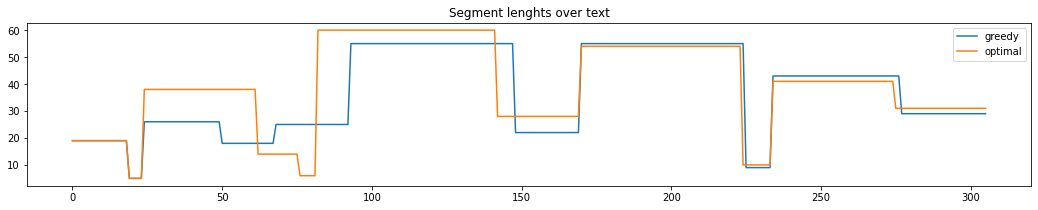

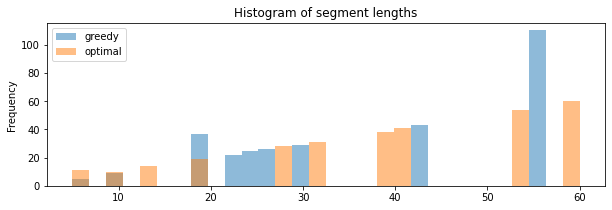

In [ ]:
strs = " "
for i in range(len(del_sponsor_sentence)):
  if(del_sponsor_sentence[i] != " "):
    strs =del_sponsor_sentence[i]
  if(i+1<len(del_sponsor_sentence)):
    if(strs == del_sponsor_sentence[i+1]):
      del_sponsor_sentence[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(del_sponsor_sentence).dot(wrdvecs)
new_length = len(del_sponsor_sentence)**0.6
print(new_length)
penalty = get_penalty([sentence_vectors], new_length)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(del_sponsor_sentence, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(del_sponsor_sentence), len(segmented_text), len(del_sponsor_sentence) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(del_sponsor_sentence, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

In [ ]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

[' Since pride month is upon us. ', 'I figured I join in on the self-serving worthless pondering. ', "So I'm happy to declare that from now on that. ", 'This is an lgbtq on a plus Channel. ', 'Well. ', "That's just something about a movie failing. ", "It's intended message through its own incompetence extra layer of 5 nuts, on top of an already fully start stirred. ", 'And if the message itself is bad, then all the more reason not to hold back. ', 'Turn off for though. ', "He's kind of different. ", 'It tells the story of a gay couple who want to get married and the frigidus, they suffer as a result. ', "It's messages about the Injustice of, not allowing same-sex marriage and the consequences of homophobia. ", "Here's the thing. ", "I don't disagree with that message. ", 'Homophobia is pretty stupid statements. ', 'Only on this channel. ', 'Yes. ', "I'd like to report that I am both stunning and brave and as the old joke goes, if gay people want to be as miserable as the rest of us. ",

In [ ]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [ ]:
headlines = headlineGenerator(podcast_test, min_length, max_length)

Ignoring args : (5, 150)


In [ ]:
for headline in headlines:
  print(headline)
  

{'generated_text': 'Gay Pride Month'}
{'generated_text': 'The Movie Bots'}
{'generated_text': 'The Movie Is a Bad Movie'}
{'generated_text': 'The School of Vybz'}
{'generated_text': "I'm a gay man, I'm a gay man, I'm"}
{'generated_text': 'The Entertainer - A Gay Rights Movie'}
{'generated_text': 'The Movie Marevich - A Novel About a Gay Man'}
{'generated_text': 'Is It a Good Idea to Get Married?'}
{'generated_text': 'The Priest Is The Most Appropriate Costing'}
{'generated_text': 'The Movie Review'}
{'generated_text': 'The Onlyfans - A Video of Me Llicking My Microphone'}


In [ ]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['Gay Pride Month']
['Gay Pride Month']
<class 'str'>
['The Movie Bots']
['The Movie Bots']
<class 'str'>
['The Movie Is a Bad Movie']
['The Movie Is a Bad Movie']
<class 'str'>
['The School of Vybz']
['The School of Vybz']
<class 'str'>
["I'm a gay man", ',', "I'm a gay man", ',', "I'm"]
["I'm a gay man", ',', ' ', ' ', "I'm"]
<class 'str'>
['The Entertainer', '-', 'A Gay Rights Movie']
['The Entertainer', '-', 'A Gay Rights Movie']
<class 'str'>
['The Movie Marevich', '-', 'A Novel About a Gay Man']
['The Movie Marevich', '-', 'A Novel About a Gay Man']
<class 'str'>
['Is It a Good Idea to Get Married?']
['Is It a Good Idea to Get Married?']
<class 'str'>
['The Priest Is The Most Appropriate Costing']
['The Priest Is The Most Appropriate Costing']
<class 'str'>
['The Movie Review']
['The Movie Review']
<class 'str'>
['The Onlyfans', '-', 'A Video of Me Llicking My Microphone']
['The Onlyfans', '-', 'A Video of Me Llicking My Microphone']
<class 'str'>


In [ ]:
for headline_string in headlines_string:
  print(headline_string)

 Gay Pride Month
 The Movie Bots
 The Movie Is a Bad Movie
 The School of Vybz
 I'm a gay man , I'm
 The Entertainer - A Gay Rights Movie
 The Movie Marevich - A Novel About a Gay Man
 Is It a Good Idea to Get Married?
 The Priest Is The Most Appropriate Costing
 The Movie Review
 The Onlyfans - A Video of Me Llicking My Microphone


In [ ]:
len(headlines_string)

11

In [ ]:
print(headlines_string)
3

[' Gay Pride Month', ' The Movie Bots', ' The Movie Is a Bad Movie', ' The School of Vybz', " I'm a gay man , I'm", ' The Entertainer - A Gay Rights Movie', ' The Movie Marevich - A Novel About a Gay Man', ' Is It a Good Idea to Get Married?', ' The Priest Is The Most Appropriate Costing', ' The Movie Review', ' The Onlyfans - A Video of Me Llicking My Microphone']


3

In [ ]:
first_sentence = []
for i in range(len(segmented_text)):
  first_sentence.append(segmented_text[i][0].strip().rstrip().rstrip('.').rstrip('?'))
  print(segmented_text[i][0])
  print(type(segmented_text[i][0]))
  print(len(segmented_text[i]))

 Since pride month is upon us. 
<class 'str'>
19
On this movie was made back in 2003. 
<class 'str'>
5
In every respect, you can think of Ben and author is a terrible film. 
<class 'str'>
38
The music is the public domain, which would be fine. 
<class 'str'>
14
Oh boy. 
<class 'str'>
6
I just fell right out onto the floor. 
<class 'str'>
60
That is glorious? 
<class 'str'>
28
Raise. 
<class 'str'>
54
Really doesn't Justice. 
<class 'str'>
10
Even referred him to a hit man. 
<class 'str'>
41
So good for him on frankly. 
<class 'str'>
31


In [ ]:
print(first_sentence)
print(len((first_sentence)))

['Since pride month is upon us', 'On this movie was made back in 2003', 'In every respect, you can think of Ben and author is a terrible film', 'The music is the public domain, which would be fine', 'Oh boy', 'I just fell right out onto the floor', 'That is glorious', 'Raise', "Really doesn't Justice", 'Even referred him to a hit man', 'So good for him on frankly']
11
